# Video diffusion models

### Unconditional training on Pokemon image dataset

In [1]:
# !wget ..

In [1]:
!rm -rf ./dataset

In [2]:
!mkdir dataset
!cp -R ../input/various-pokemon-image-dataset/ani/*.gif ./dataset
!cp -R ../input/various-pokemon-image-dataset/ani/pokemon-ani/*.gif ./dataset
!cp -R ../input/various-pokemon-image-dataset/ani-shiny/*.gif ./dataset
# !ls ./dataset/*

In [3]:
# Params
image_size = 64
frames = 20
process_batch_size = 256

max_run_minutes = 12 * 60 - 10

In [4]:
import time
import os
start_time = time.time()

## Install dependencies

In [5]:
!pip install imagen_pytorch==1.18.11 --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 774.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.5/754.5 kB 4.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 137.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-b

## Utility functions to resize and crop GIFs

In [6]:
# GIF pre-processing

import numpy as np
from torchvision import transforms as T
from math import floor, fabs
from PIL import Image, ImageSequence


CHANNELS_TO_MODE = {
    1 : 'L',
    3 : 'RGB',
    4 : 'RGBA'
}

def center_crop(img, new_width, new_height): 
    width = img.size[0]
    height = img.size[1]
    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))
    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))
    return img.crop((left, top, right, bottom))

def resize_crop_img(img, width, height):
    # width < height
    if( img.size[0] < img.size[1]):
        wpercent = (width/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((width, hsize), Image.Resampling.LANCZOS)
    else: # width >= height
        hpercent = (height/float(img.size[1]))
        wsize = int((float(img.size[0])*float(hpercent)))
        img = img.resize((wsize, height), Image.Resampling.LANCZOS)
    img = center_crop(img, width, height)
    return img

def transform_gif(img, new_width, new_height, frames, channels = 3):
    assert channels in CHANNELS_TO_MODE, f'channels {channels} invalid'
    mode = CHANNELS_TO_MODE[channels]
    gif_frames = img.n_frames
    for i in range(0, frames):
        img.seek(i % gif_frames)
        if img.size[0] != new_width or img.size[1] != new_height:
#             print("Resizing")
            img_out = resize_crop_img(img, new_width, new_height)
        else:
            img_out = img
        yield img_out.convert(mode)
        
# tensor of shape (channels, frames, height, width) -> gif
def video_tensor_to_gif(tensor, path, fps = 10, loop = 0, optimize = True):
    print("Converting video tensors to GIF")
    images = map(T.ToPILImage(), tensor.unbind(dim = 1))
    first_img, *rest_imgs = images
    print(1000/fps)
    first_img.save(path, save_all = True, append_images = rest_imgs, duration = int(1000/fps), loop = loop, optimize = optimize)
    print("Gif saved")
    return images

# gif -> (channels, frame, height, width) tensor
def gif_to_tensor(path, width = 256, height = 256, frames = 32, channels = 3, transform = T.ToTensor()):
#     print(f"Converting {path} to video tensors")
    img = Image.open(path)
    imgs = transform_gif(img, new_width = width, new_height = height, frames = frames, channels = channels)
    tensors = tuple(map(transform, imgs))
    return torch.stack(tensors, dim = 1)


## Utility functions to process dataset

In [15]:
import os
import torch
import shutil
import urllib
import traceback

from concurrent.futures import ThreadPoolExecutor, wait
import time
import threading
import fnmatch

data_dir = "./dataset"
dataset_files = fnmatch.filter(os.listdir(data_dir), '*.gif')
dataset_size = len(dataset_files)

current_step = 0
list_videos = []
list_texts = []

lock = threading.Lock()
executor = ThreadPoolExecutor(max_workers=15)

def get_text_from_path(path):
    out = path.split('/')[-1]
    out = out.split('.')[0]
    out = out.replace('-', ' ')
    out = out.replace('_', ' ')
    return out
    
def process_parallel(file_img):
    global list_videos
    global list_texts
    try:
    #     print(f"Processing image {file_img}")
        tensor = gif_to_tensor(file_img, width = image_size, height = image_size, frames = frames)
        with lock:
            list_videos.append(tensor)
            list_texts.append(get_text_from_path(file_img))
    except:
        traceback.print_exc()
    
def get_videos_parallel(index_start, index_end):
    print(f"Get videos {index_start} - {index_end}")
    global list_videos
    list_videos = []
    futures = []
    for i in range(index_start, index_end):
        if i >= dataset_size:
            break;
        future = executor.submit(process_parallel, os.path.join(data_dir, dataset_files[i]))
        futures.append(future)
    wait(futures)
                
def get_next_videos():
    global current_step
    get_videos_parallel(current_step, current_step + process_batch_size)
    current_step += len(list_videos)


## Utility functions to save and load checkpoints

In [16]:
import shutil
import torch
import time
import gc
import os
from imagen_pytorch import Unet3D, ElucidatedImagen, ImagenTrainer
from imagen_pytorch.data import Dataset

checkpoints_path = "./"
checkpoint_path = ""

# If there is a checkpoint these changes automatically at runtime
epoch_1 = 0
epoch_2 = 0

step_1 = 0
step_2 = 0

train_unet = 1

def save_checkpoint(trainer: ImagenTrainer):
    global checkpoint_path
    global current_step
    global epoch_1
    global epoch_2
    global step_1
    global step_2
    print("Saving checkpoint")
    current_time = int(time.time())
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
    if train_unet == 1:
        step_1 = current_step
    else:
        step_2 = current_step
    checkpoint_path = os.path.join(checkpoints_path, f"checkpoint-e1_{epoch_1}-s1_{step_1}-e2_{epoch_2}-s2_{step_2}-{current_time}.pt")
    trainer.save(checkpoint_path)

def update_config(checkpoint):
    global epoch_1
    global epoch_2
    global step_1
    global step_2
    global train_unet
    global current_step
    splitted = (checkpoint.replace(".pt", "").split("checkpoint-")[1]).split("-")
    epoch_1 = int(splitted[0].replace("e1_", ""))
    step_1 = int(splitted[1].replace("s1_", ""))
    epoch_2 = int(splitted[2].replace("e2_", ""))
    step_2 = int(splitted[3].replace("s2_", ""))
    print("Loaded configuration")
    print(f"Epoch unet 1: {epoch_1}")
    print(f"Steps unet 1: {step_1}")
    print(f"Epoch unet 2: {epoch_2}")
    print(f"Steps unet 2: {step_2}")
    if epoch_2 >= epoch_1:
        train_unet = 1
        if step_1 >= dataset_size:
            current_step = 0
            epoch_1 += 1
        else:
            current_step = step_1
    else:
        train_unet = 2
        if step_2 >= dataset_size:
            current_step = 0
            epoch_2 += 1
        else:
            current_step = step_2
    print(f"Unet {train_unet} selected")
    print(f"Current step: {current_step}")
    
def config_new_epoch():
    global epoch_1
    global epoch_2
    global train_unet
    global current_step
    if train_unet == 1:
        epoch_1 += 1
    else:
        epoch_2 += 1
    current_step = 0
        
def load_checkpoint(trainer: ImagenTrainer):
    global checkpoint_path
    global epoch_1
    global epoch_2
    global step_1
    global step_2
    global train_unet
    global current_step
    print("Loading checkpoint")
    timestamp = -1
    for file in os.listdir(checkpoints_path):
        if file.endswith('.pt'):
            new_timestamp = int((file.split("-")[-1]).replace(".pt", ""))
            if new_timestamp > timestamp:
                checkpoint_path = os.path.join(checkpoints_path, file)
                timestamp = new_timestamp        
    if not os.path.exists(checkpoint_path):
        print("No checkpoint found -> starting from scratch")
        epoch_1 = 0
        epoch_2 = 0
        step_1 = 0
        step_2 = 0
        current_step = 0
        train_unet = 1
        return None
    trainer.load(checkpoint_path)
    update_config(checkpoint_path)

Downloading:   0%|          | 0.00/605 [00:00<?, ?B/s]

In [17]:
unet1 = Unet3D(
    dim = 64,
    cond_dim = 64,
    dim_mults = (1, 2, 4, 8),
)

unet2 = Unet3D(
    dim = 64,
    cond_dim = 64,
    dim_mults = (1, 2, 4, 8),
)

imagen = ElucidatedImagen(
    unets = (unet1, unet2),
    condition_on_text = False,
    image_sizes = (16, 64),
    random_crop_sizes = (None, 16),
    num_sample_steps = 64,
    cond_drop_prob = 0.2,                       # gives the probability of dropout for classifier-free guidance.
    sigma_min = 0.002,                          # min noise level
    sigma_max = (80, 160),                      # max noise level, double the max noise level for upsampler
    sigma_data = 0.5,                           # standard deviation of data distribution
    rho = 7,                                    # controls the sampling schedule
    P_mean = -1.2,                              # mean of log-normal distribution from which noise is drawn for training
    P_std = 1.2,                                # standard deviation of log-normal distribution from which noise is drawn for training
    S_churn = 80,                               # parameters for stochastic sampling - depends on dataset, Table 5 in apper
    S_tmin = 0.05,
    S_tmax = 50,
    S_noise = 1.003,
).cuda()

trainer = ImagenTrainer(imagen)


The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


## Train Unet

In [19]:
# Train 
load_checkpoint(trainer)
while True:
    # if execution time is more than max_run_minutes stops
    if time.time() - start_time >= max_run_minutes * 60:
        break
    get_next_videos()
    if len(list_videos) == 0:
        save_checkpoint(trainer)
        config_new_epoch()
        get_next_videos()
#         break
    print("Generating tensor from videos")
    videos = torch.stack(list_videos, dim = 0).cuda()
    print(f"Training Unet {train_unet}")
    trainer(videos, texts = list_texts, unet_number = train_unet, max_batch_size = 32)
    trainer.update(unet_number = train_unet)
    del videos
save_checkpoint(trainer)

Loading checkpoint
No checkpoint found -> starting from scratch
Get videos 0 - 256
Generating tensor from videos
Training Unet 1


KeyboardInterrupt: 

## Sampling

In [12]:
texts_sample = ['pikachu']
load_checkpoint(trainer)
videos_out = trainer.sample(texts = texts_sample, video_frames = 30)
print(videos_out.shape)
video_tensor_to_gif(videos_out[0], f'out.gif', fps = 5)

Loading checkpoint

checkpoint loaded from ./checkpoint-e1_453-s1_512-e2_0-s2_0-1674288485.pt

Loaded configuration

Epoch unet 1: 453

Steps unet 1: 512

Epoch unet 2: 0

Steps unet 2: 0

Unet 2 selected

Current step: 0

unet 2 has not been trained

when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/64 [00:00<?, ?it/s]

sampling time step:   0%|          | 0/64 [00:00<?, ?it/s]

torch.Size([1, 3, 30, 64, 64])

Converting video tensors to GIF

200.0

Gif saved


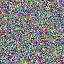

In [13]:
from IPython.display import Image
Image(open('out.gif','rb').read())